In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

('The first anchor box at row 21, column 21:', 
[0.2625 0.2625 0.7625 0.7625]
<NDArray 4 @cpu(0)>)


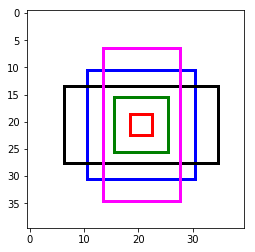

In [33]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [37]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print"Class prediction", cls_pred(x).shape



Class prediction (2L, 55L, 20L, 20L)


In [38]:
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding=1)
box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

('Box prediction', (2L, 40L, 20L, 20L))


In [39]:
def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out 
blk = down_sample(10)
blk.initialize()
x = nd.zeros((2,3,20,20))
print('Before', x.shape, 'after', blk(x).shape)

('Before', (2L, 3L, 20L, 20L), 'after', (2L, 10L, 10L, 10L))


In [40]:
feat1 = nd.zeros((2,8,20,20))
print("Feature map 1", feat1.shape)
cls_pred1 = class_predictor(5,10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print "Class prediction for feature map 1', y1.shape"
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print("feature map 2", feat2.shape)
cls_pred2 = class_predictor(3,10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)

('Feature map 1', (2L, 8L, 20L, 20L))
Class prediction for feature map 1', y1.shape
('feature map 2', (2L, 16L, 10L, 10L))


In [42]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0,2,3,1)))

def concat_predictions(preds):
    return nd.concat(*preds,dim=1)

flat_y1 = flatten_prediction(y1)
print 'Flatten class prediction 1', flat_y1.shape
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)


Flatten class prediction 1 (2L, 22000L)
('Flatten class prediction 2', (2L, 3300L))
('Concat class predictions', (2L, 25300L))


In [43]:
from mxnet import gluon
def body():
    out = nn.HybridSequential()
    for nfilters in [16,32,64]:
        out.add(down_sample(nfilters))
    return out
bnet = body()
bnet.initialize()
x = nd.zeros((2,3,256,256))
print('Body network', [y.shape for y in bnet(x)])

('Body network', [(64L, 32L, 32L), (64L, 32L, 32L)])
